In [0]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.dataframe import DataFrame
import pyspark.sql.functions as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [0]:
# Loading the csv into spark dataFrame:
data = spark.read.csv("dbfs:/FileStore/shared_uploads/vkoyya@saintpeters.edu/spotify_dataset.csv", header=True, inferSchema=True)
# Shows the DataFrame schema:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- track_genre: string (nullable = true)



In [0]:
# Shows the DataFrame sample data:
data.show()

+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+
|_c0|            track_id|             artists|          album_name|          track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|track_genre|
+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+
|  0|5SuOikwiRyPMVoIQD...|         Gen Hoshino|              Comedy|              Comedy|        73|     230666|   False|       0.676| 0.461|  1|  -6.746|   0|      0.143|      0.0322|         1.01E-6|   0.358|  0.715| 87.917|           4

In [0]:
# Count the number of columns in the Spark DataFrame
num_columns = len(data.columns)
print("Number of Columns:", num_columns)

Number of Columns: 21


In [0]:
# Count the number of records (rows) in the Spark DataFrame
num_records = data.count()
print("Number of Records:", num_records)

Number of Records: 114000


In [0]:
#To check the information about the DataFrame. 
data.describe()

DataFrame[summary: string, _c0: string, track_id: string, artists: string, album_name: string, track_name: string, popularity: string, duration_ms: string, explicit: string, danceability: string, energy: string, key: string, loudness: string, mode: string, speechiness: string, acousticness: string, instrumentalness: string, liveness: string, valence: string, tempo: string, time_signature: string, track_genre: string]

In [0]:
# Remove duplicates from the DataFrame
df = data.dropDuplicates()

# Renaming the first column to "S_NO" (Want to rename '_c0' it is the first column)
new_columns = ['S_NO' if col == df.columns[0] else col for col in df.columns]
df = df.toDF(*new_columns)

# Fill null values with zeros in the DataFrame
df = df.fillna(0)

# Count the number of records after preprocessing
num_records_after = df.count()
print("Number of Records after preprocessing:", num_records_after)

Number of Records after preprocessing: 114000


In [0]:
# Function to find unique values and counts for each column
def unique_val(column_name):
    unique_values = df.select(column_name).distinct().collect()
    count_unique = len(unique_values)
    print("---------------------------------------------------------------")
    print(f"Count of unique values for column '{column_name}':", count_unique)
    print("---------------------------------------------------------------")
    df.groupBy(column_name).count().orderBy(F.col("count").desc()).show()
    out = df.groupBy(column_name).count().orderBy(F.col("count").desc()).limit(5)
    return out

In [0]:
# Call the function for artists column in the DataFrame
unique_val('artists')

---------------------------------------------------------------
Count of unique values for column 'artists': 31438
---------------------------------------------------------------
+--------------------+-----+
|             artists|count|
+--------------------+-----+
|         The Beatles|  279|
|        George Jones|  271|
|       Stevie Wonder|  236|
|         Linkin Park|  224|
|     Ella Fitzgerald|  222|
|       Prateek Kuhad|  217|
|                Feid|  202|
|         Chuck Berry|  190|
|     Håkan Hellström|  183|
|         OneRepublic|  181|
|      The Beach Boys|  176|
|   my little airport|  171|
|       Elvis Presley|  169|
|   Charlie Brown Jr.|  169|
|Red Hot Chili Pep...|  159|
|         Bryan Adams|  157|
|             Scooter|  155|
|        Daddy Yankee|  154|
|      Arctic Monkeys|  152|
|                 BTS|  151|
+--------------------+-----+
only showing top 20 rows



DataFrame[artists: string, count: bigint]

In [0]:
# Call the function for track_genre column in the DataFrame
unique_val('track_genre')

---------------------------------------------------------------
Count of unique values for column 'track_genre': 152
---------------------------------------------------------------
+-----------------+-----+
|      track_genre|count|
+-----------------+-----+
|            malay| 1000|
|        bluegrass| 1000|
|        breakbeat| 1000|
|singer-songwriter| 1000|
|            dance| 1000|
|           groove| 1000|
|           indian| 1000|
|              pop| 1000|
|      alternative| 1000|
|      death-metal| 1000|
|   detroit-techno| 1000|
|              sad| 1000|
|            k-pop| 1000|
|          spanish| 1000|
|          ambient| 1000|
|           french| 1000|
|             goth| 1000|
|       electronic| 1000|
|            blues| 1000|
|           brazil| 1000|
+-----------------+-----+
only showing top 20 rows



DataFrame[track_genre: string, count: bigint]

In [0]:
# Categorizing speechiness into types 'Low', 'Medium', and 'High'
df = df.withColumn("speechiness_type", 
                   F.when(df["speechiness"] < 0.33, "Low")
                   .when((df["speechiness"] >= 0.33) & (df["speechiness"] <= 0.66), "Medium")
                   .otherwise("High"))

# Count the occurrences of each speechiness type
result = df.groupBy("speechiness_type").count()
result.show()

+----------------+------+
|speechiness_type| count|
+----------------+------+
|            High|   955|
|             Low|110315|
|          Medium|  2730|
+----------------+------+



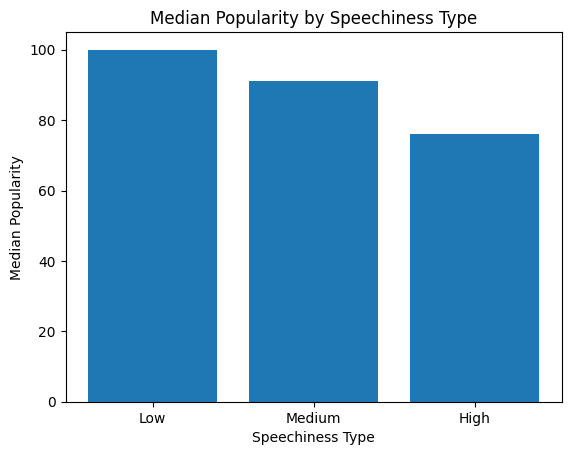

In [0]:
df = df.withColumn("popularity", df["popularity"].cast("int"))
Popularity = df.toPandas()
# Plotting using Matplotlib
plt.bar(Popularity["speechiness_type"], Popularity["popularity"])
plt.xlabel("Speechiness Type")
plt.ylabel("Median Popularity")
plt.title("Median Popularity by Speechiness Type")
plt.show()

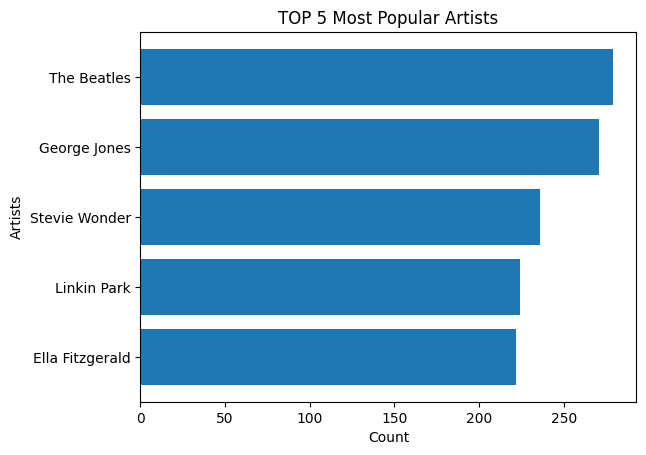

In [0]:
top_five_artists = df.groupBy("artists").count().orderBy("count", ascending=False).limit(5)

# Collecting data into the driver 
top_five_artists_list = top_five_artists.collect()

# Extracting artist names and counts for plotting
artist_names = [row['artists'] for row in top_five_artists_list]
artist_counts = [row['count'] for row in top_five_artists_list]

# Plotting using Matplotlib
plt.barh(artist_names, artist_counts)
plt.xlabel("Count")
plt.ylabel("Artists")
plt.title("TOP 5 Most Popular Artists")
plt.gca().invert_yaxis()  
plt.show()

+--------------------+-----------+
|          track_name|duration_ms|
+--------------------+-----------+
|      Waves To Sleep|      99999|
|        Sakura Trees|      99996|
|Vai Ver É Assim M...|      99985|
| Mumbles the Monster|      99973|
|The Grand Old Duk...|      99960|
+--------------------+-----------+



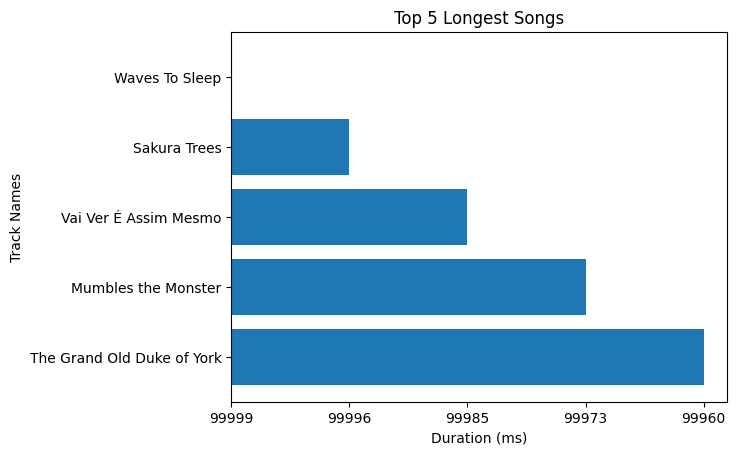

In [0]:
# Selecting the columns 'track_name' and 'duration_ms', sorting by 'duration_ms' in descending order, and getting the top 5 longest songs
long_songs = df.select("track_name", "duration_ms").where(~F.col("track_name").contains("Odeon")).distinct().orderBy("duration_ms", ascending=False).limit(5)
df.select("track_name", "duration_ms").where(~F.col("track_name").contains("Odeon")).distinct().orderBy("duration_ms", ascending=False).limit(5).show()
# Collecting data into the driver (Python)
long_songs_list = long_songs.collect()

# Extracting track names and duration for plotting
track_names = [row['track_name'] for row in long_songs_list]
durations = [row['duration_ms'] for row in long_songs_list]

# Plotting using Matplotlib
plt.barh(track_names, durations)
plt.xlabel("Duration (ms)")
plt.ylabel("Track Names")
plt.title("Top 5 Longest Songs")
plt.gca().invert_yaxis()  
plt.show()

+----------+--------+
|popularity|loudness|
+----------+--------+
|       100|  -7.375|
|        99|  -5.548|
|        98|  -3.673|
|        98|  -5.329|
|        97|  -5.198|
|        97|  -5.105|
|        96|  -5.529|
|        96|  -8.797|
|        96|  -5.927|
|        95|  -5.338|
+----------+--------+



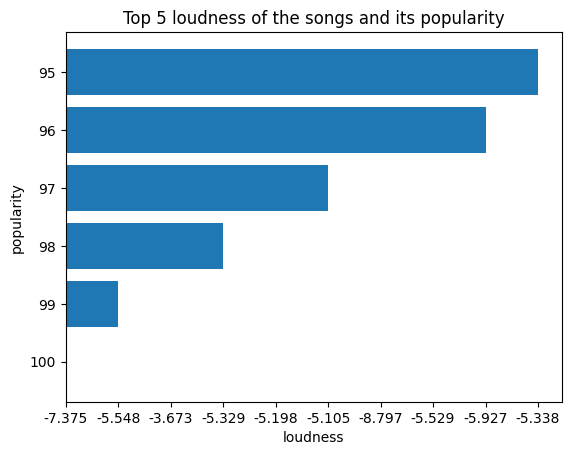

In [0]:
songs = df.select("popularity", "loudness").where(~F.col("track_name").contains("Odeon")).distinct().orderBy("popularity", ascending=False).limit(10)
df.select("popularity", "loudness").where(~F.col("track_name").contains("Odeon")).distinct().orderBy("popularity", ascending=False).limit(10).show()
# Collecting data into the driver
songs_list = songs.collect()

# Extracting popularity and loudness for plotting
popularity = [row['popularity'] for row in songs_list]
loudness = [row['loudness'] for row in songs_list]

# Plotting using Matplotlib
plt.barh(popularity, loudness)
plt.xlabel("loudness")
plt.ylabel("popularity")
plt.title("Top 5 loudness of the songs and its popularity")
plt.gca().invert_yaxis()  
plt.show()

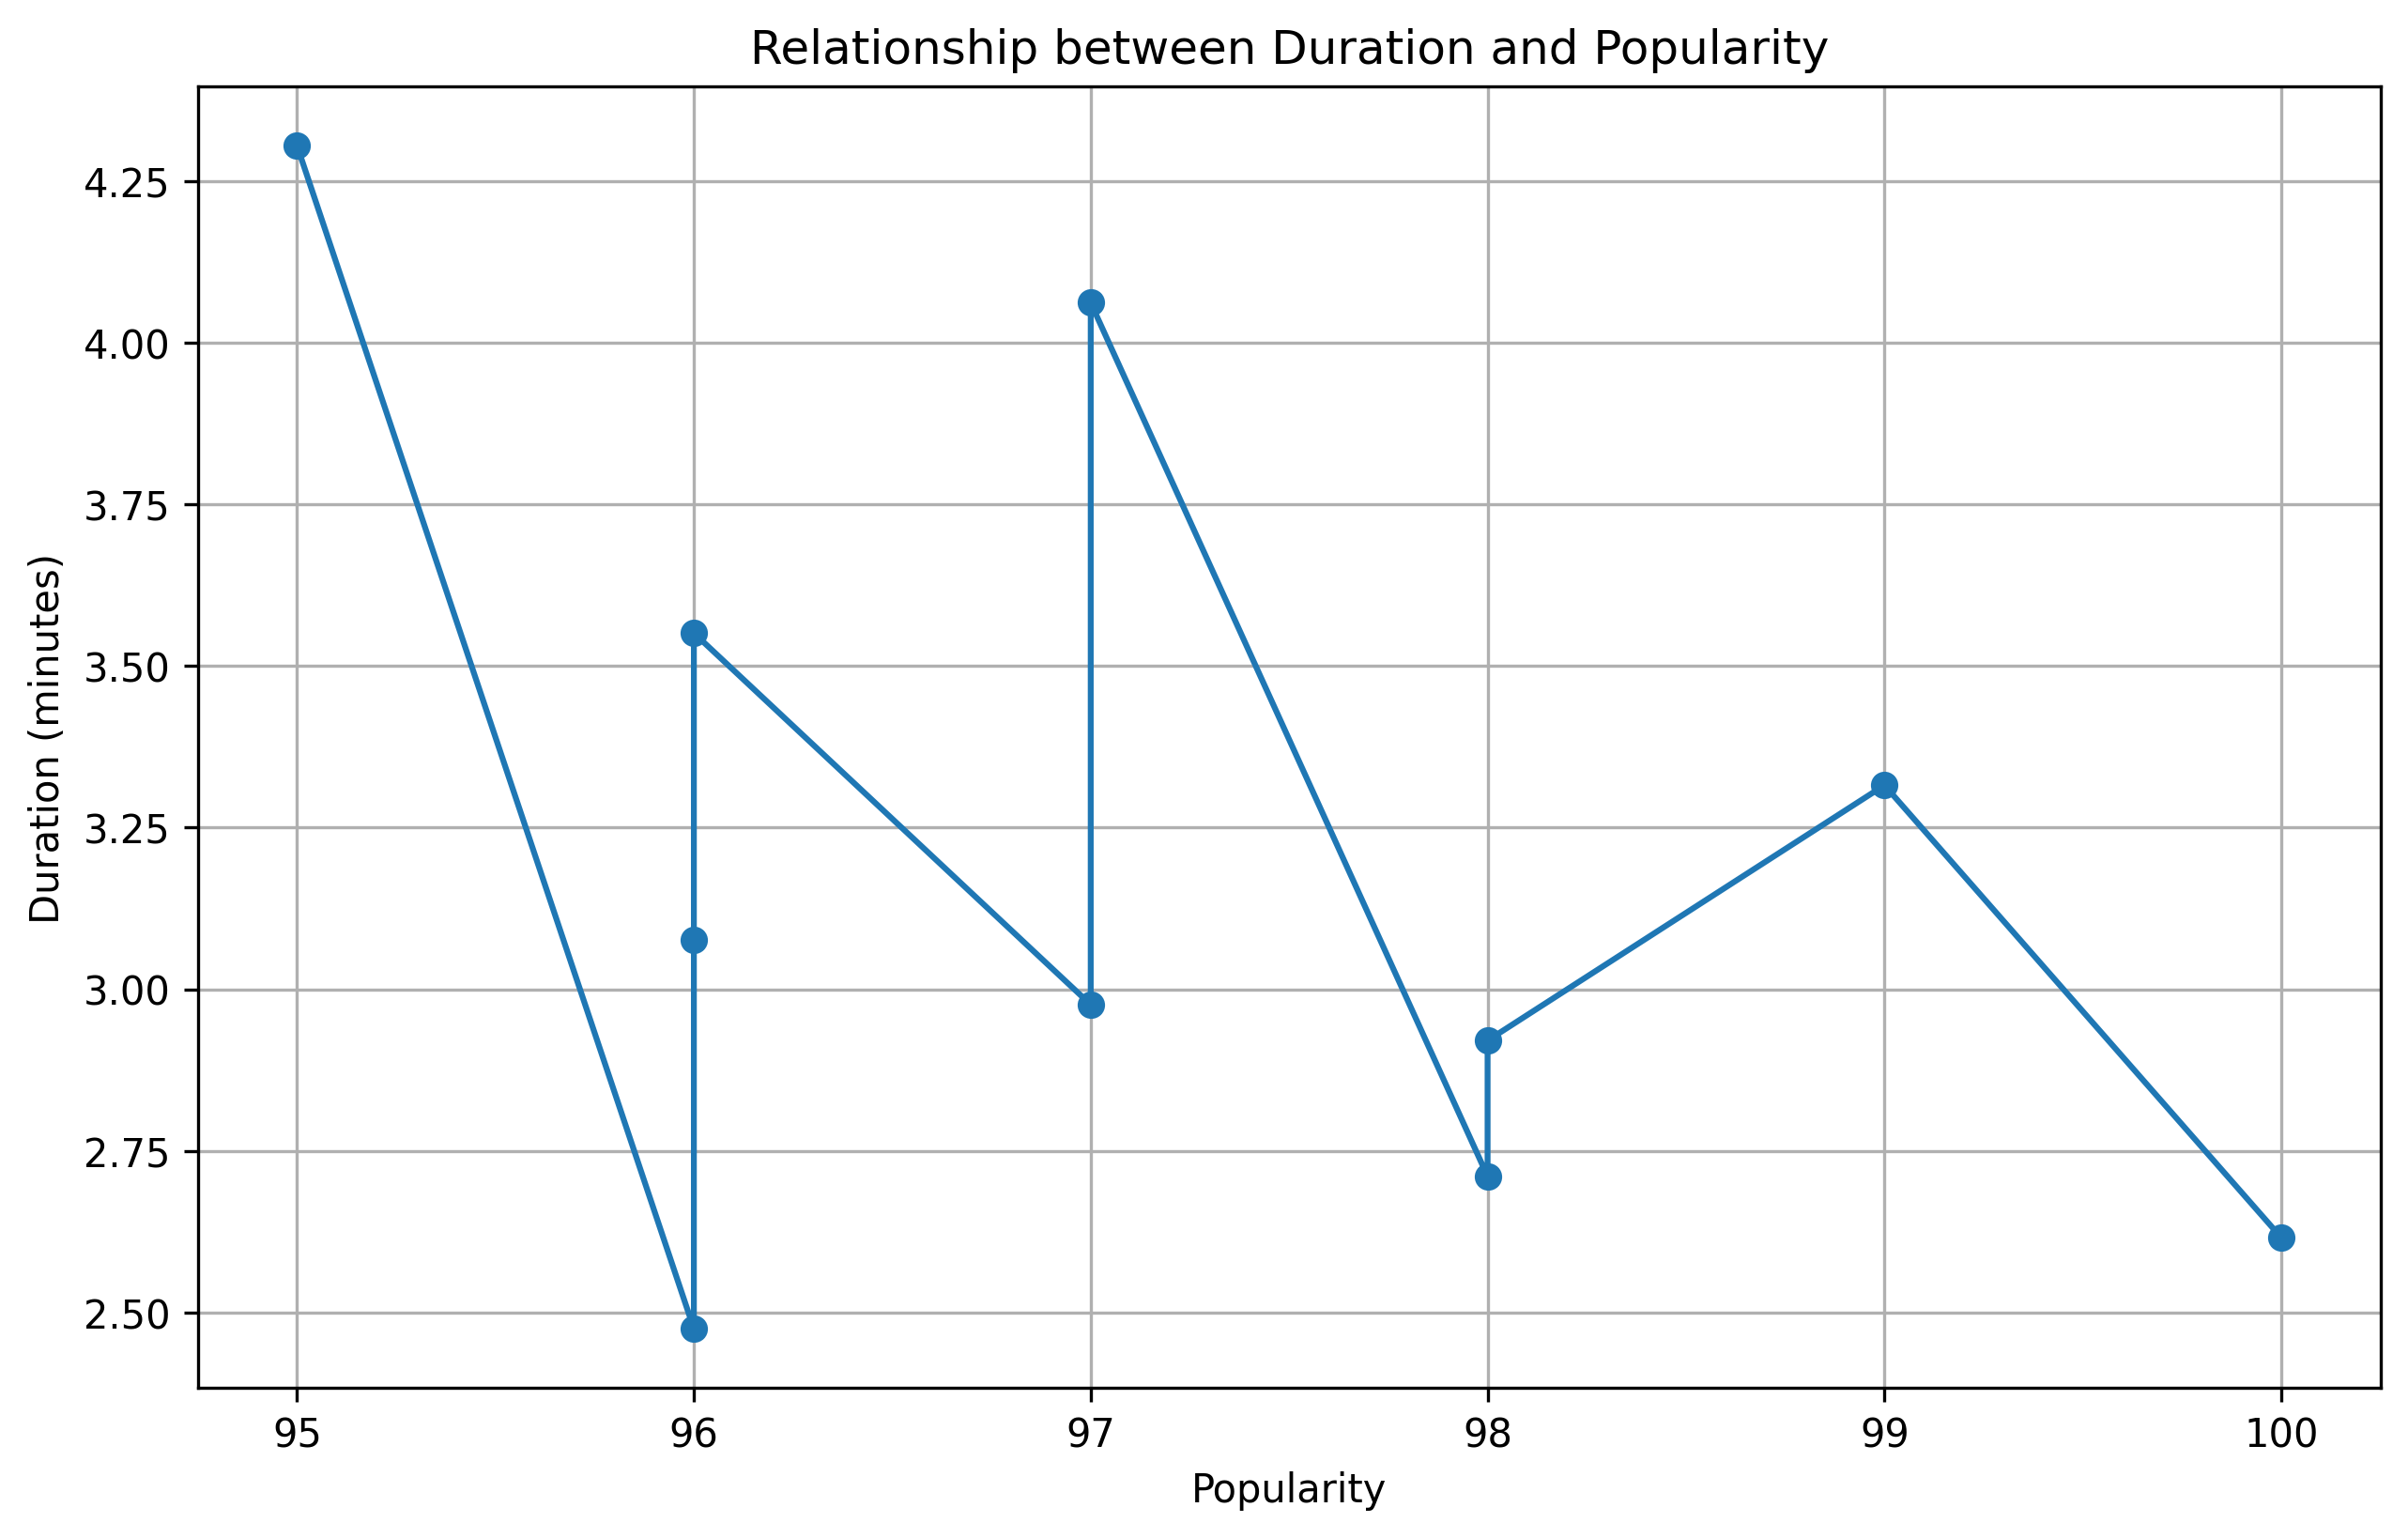

In [0]:
df_with_minutes = df.withColumn("duration_min", F.expr("duration_ms / 60000"))  # 60000 ms = 1 minute

# Filtering data and selecting necessary columns
songs = (
    df_with_minutes
    .select("popularity", "duration_min")
    .where(~F.col("track_name").contains("Odeon"))
    .distinct()
    .orderBy("popularity", ascending=False)
    .limit(10)
)

# Collecting data into the driver
songs_list = songs.collect()

# Extracting popularity and duration_min for plotting
popularity = [row['popularity'] for row in songs_list]
duration_min = [row['duration_min'] for row in songs_list]

# Plotting using Matplotlib - Line Graph
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(popularity,duration_min , marker='o', linestyle='-')
plt.xlabel("Popularity")
plt.ylabel("Duration (minutes)")
plt.title("Relationship between Duration and Popularity")
plt.grid(True)
plt.show()

In [0]:
# Selecting 'track_genre' and 'popularity', sorting by 'popularity' in descending order, and getting the top 6 rows
top_genres = df.select("track_genre", "popularity").orderBy("popularity", ascending=False).limit(6)

# Dropping duplicates based on 'track_genre'
trend_genre = top_genres.dropDuplicates(["track_genre"])

# Display the resulting DataFrame
trend_genre.show()

+-----------+----------+
|track_genre|popularity|
+-----------+----------+
|        pop|       100|
|      dance|       100|
|    hip-hop|        99|
|     latino|        98|
|     reggae|        98|
+-----------+----------+



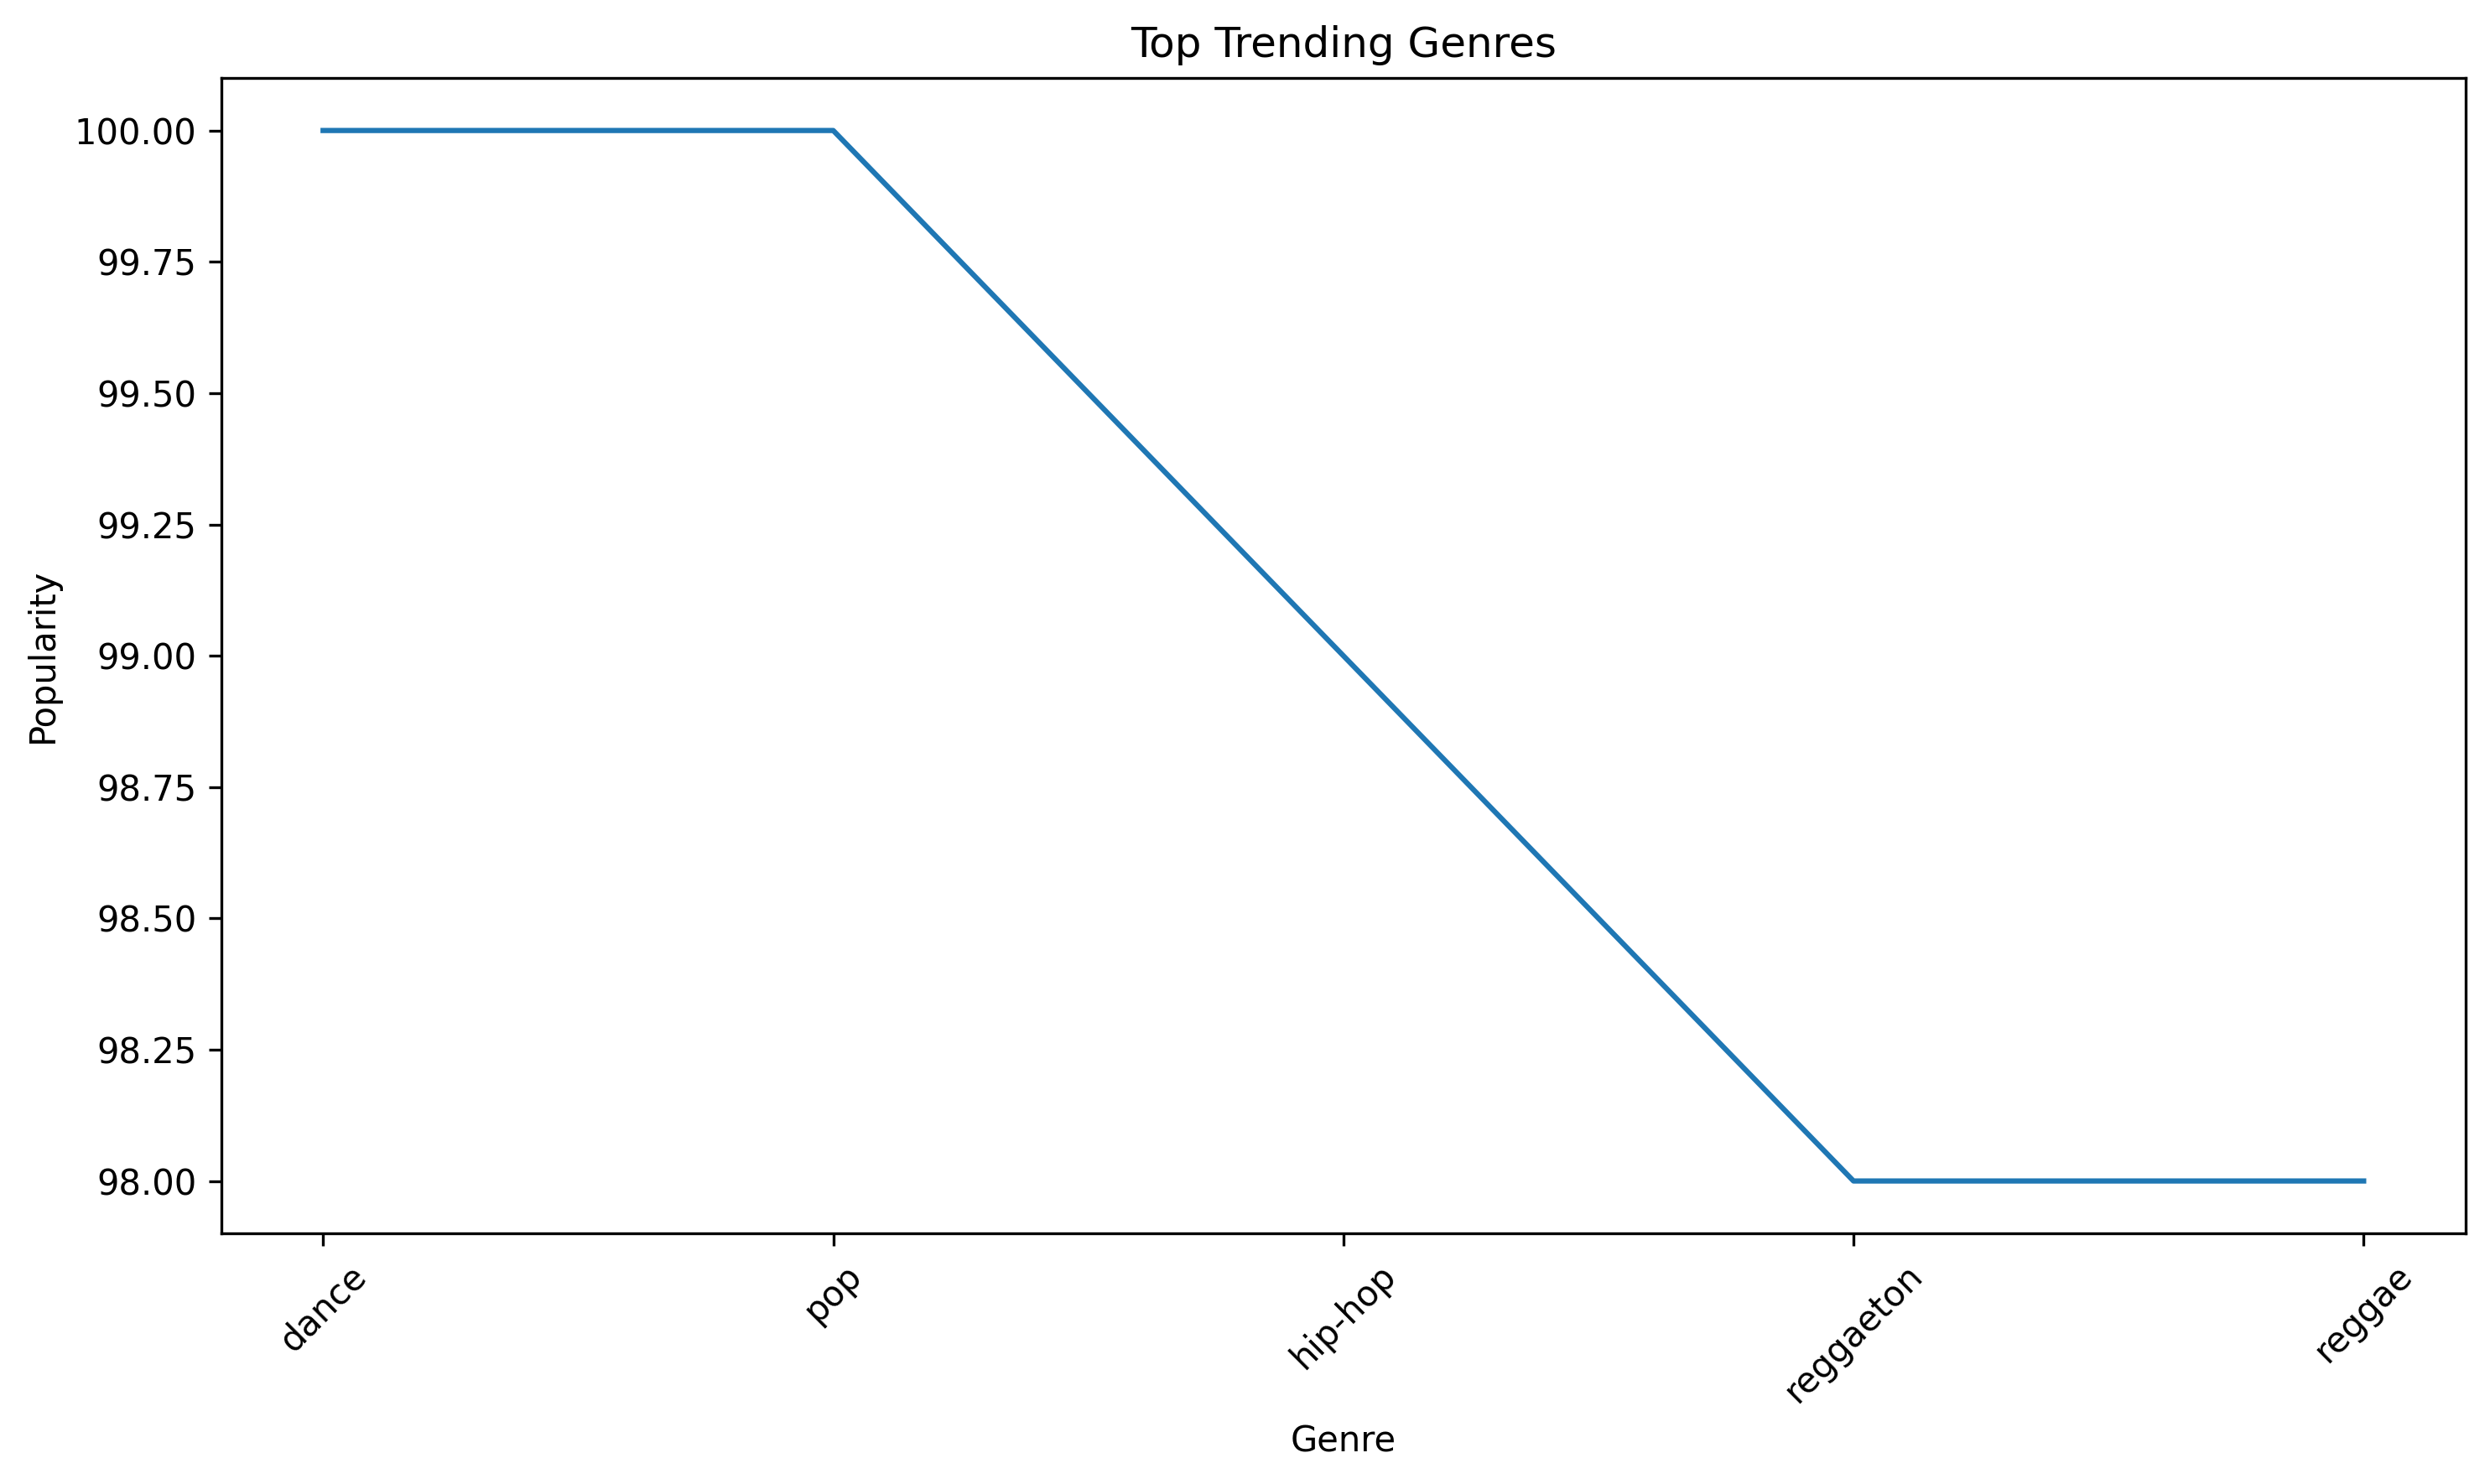

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame for visualization
trend_genre_pandas = trend_genre.toPandas()

# Use Seaborn for plotting a line plot
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(x="track_genre", y="popularity", data=trend_genre_pandas)
plt.title("Top Trending Genres")
plt.xlabel("Genre")
plt.ylabel("Popularity")
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


In [0]:
lyrics_df = df.select("track_name", "artists", "album_name").dropna(subset=["album_name"])

# Tokenize album names and explode them into separate words
lyrics_df = lyrics_df.withColumn("words", F.explode(F.split(F.lower(F.col("album_name")), " ")))

# Remove stop words and non-alphabetic characters, count word occurrences
stop_words = ["a", "an", "the", "and", "or", "in", "of", "for", "on", "with", "at"]  # Add more if needed
lyrics_df = (
    lyrics_df
    .filter((F.col("words").rlike(r"^[a-zA-Z]+$")) & (~F.col("words").isin(stop_words)))
    .groupBy("words")
    .agg(F.count("*").alias("word_count"))
    .orderBy(F.col("word_count").desc())
)

# Display the 20 most common words in the album names
lyrics_df.show(20)


+---------+----------+
|    words|word_count|
+---------+----------+
|christmas|      3140|
|       de|      2882|
|     hits|      2365|
|      you|      1984|
|     best|      1928|
|   motion|      1893|
|  picture|      1808|
|       to|      1781|
|halloween|      1675|
|        i|      1574|
|     love|      1453|
|       me|      1410|
|     rock|      1405|
|      pop|      1393|
|       la|      1387|
|    music|      1347|
|    songs|      1235|
|   perreo|      1211|
|      all|      1130|
|    party|      1093|
+---------+----------+
only showing top 20 rows

